# Aug 25, 2025: compare graphs created from 
- (1) concatenating run-wise time series, and 
- (2) averaging Fisher r-to-z transformed run-wise graphs

In [1]:
import os
import glob
import pandas as pd
import re
import numpy as np
from tqdm import tqdm
from itertools import product, combinations
from sklearn.covariance import GraphicalLasso
from scipy.stats import entropy, zscore
from sklearn.metrics import mutual_info_score
from joblib import Parallel, delayed
import graph_tool.all as gt 
import seaborn as sns

import networkx as nx
from scipy.stats import hypergeom, pearsonr, wasserstein_distance
from scipy.sparse.csgraph import laplacian as csgraph_laplacian

# plotting
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from cycler import cycler
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

np.random.seed(args.SEED)

In [3]:
args.source = 'allen' #'allen'
args.space = 'ccfv2' #'ccfv2'
args.brain_div = 'whl' #'whl'
args.num_rois = 172 #216 #334 #162 #172
args.resolution = 200 #200

PARC_DESC = (
    f'source-{args.source}'
    f'_space-{args.space}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
    f'_res-{args.resolution}'
)
PARC_DESC

'source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200'

In [4]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson'
args.THRESHOLD = f'signed'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'sub' #f'grp' #f'sub'

BASE_path = f'{os.environ["HOME"]}/new_mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = (
    f'{BASE_path}/roi-results-v3'
    f'/{PARC_DESC}'
)
TS_path = f'{ROI_path}/roi_timeseries'
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')

0

In [5]:
PARC_DESC_concat = f'{PARC_DESC}_desc-ts-concat'
ROI_path_concat = (
    f'{BASE_path}/roi-results-v3'
    f'/{PARC_DESC_concat}'
)
ROI_RESULTS_path_concat = (
    f'{ROI_path_concat}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path_concat = f'{ROI_RESULTS_path_concat}/graphs'

In [6]:
graph_files = sorted(glob.glob(f'{GRAPH_path}/*'))
graphs = [gt.load_graph(gfile) for gfile in graph_files]
graphs

[<Graph object, undirected, with 172 vertices and 2942 edges, 1 internal edge property, at 0x7f339c7969a0>,
 <Graph object, undirected, with 172 vertices and 2942 edges, 1 internal edge property, at 0x7f3340a9b5e0>,
 <Graph object, undirected, with 172 vertices and 2942 edges, 1 internal edge property, at 0x7f339e0252b0>,
 <Graph object, undirected, with 172 vertices and 2942 edges, 1 internal edge property, at 0x7f339c5f5a30>,
 <Graph object, undirected, with 172 vertices and 2942 edges, 1 internal edge property, at 0x7f339c5f5c10>,
 <Graph object, undirected, with 172 vertices and 2942 edges, 1 internal edge property, at 0x7f33409f05e0>,
 <Graph object, undirected, with 172 vertices and 2942 edges, 1 internal edge property, at 0x7f339c79d640>,
 <Graph object, undirected, with 172 vertices and 2942 edges, 1 internal edge property, at 0x7f33409ffa90>,
 <Graph object, undirected, with 172 vertices and 2942 edges, 1 internal edge property, at 0x7f3340a25580>]

In [7]:
graph_concat_files = sorted(glob.glob(f'{GRAPH_path_concat}/*'))
graphs_concat = [gt.load_graph(gfile) for gfile in graph_concat_files]
graphs_concat

[<Graph object, undirected, with 172 vertices and 2942 edges, 1 internal edge property, at 0x7f337bf075e0>,
 <Graph object, undirected, with 172 vertices and 2942 edges, 1 internal edge property, at 0x7f339c607040>,
 <Graph object, undirected, with 172 vertices and 2942 edges, 1 internal edge property, at 0x7f3340a25d60>,
 <Graph object, undirected, with 172 vertices and 2942 edges, 1 internal edge property, at 0x7f33409ab520>,
 <Graph object, undirected, with 172 vertices and 2942 edges, 1 internal edge property, at 0x7f33409ab880>,
 <Graph object, undirected, with 172 vertices and 2942 edges, 1 internal edge property, at 0x7f33409abc40>,
 <Graph object, undirected, with 172 vertices and 2942 edges, 1 internal edge property, at 0x7f33409abfd0>,
 <Graph object, undirected, with 172 vertices and 2942 edges, 1 internal edge property, at 0x7f33409abfa0>,
 <Graph object, undirected, with 172 vertices and 2942 edges, 1 internal edge property, at 0x7f33409b07c0>]

In [8]:
def adjacency_matrix(g):
    A = np.zeros((g.num_vertices(), g.num_vertices()), dtype=int)
    edges = [list(edge) for edge in list(g.get_edges())]
    v1, v2 = list(zip(*edges))
    weights = list(g.ep['weight'])
    A[v1, v2] = weights
    A = (A + A.T)
    return A

In [9]:
As = [adjacency_matrix(g) for g in graphs]
As_concat = [adjacency_matrix(g) for g in graphs_concat]

In [10]:
def _upper_triangle_bool(A):
    n = A.shape[0]
    iu = np.triu_indices(n, k=1)
    return A[iu], iu

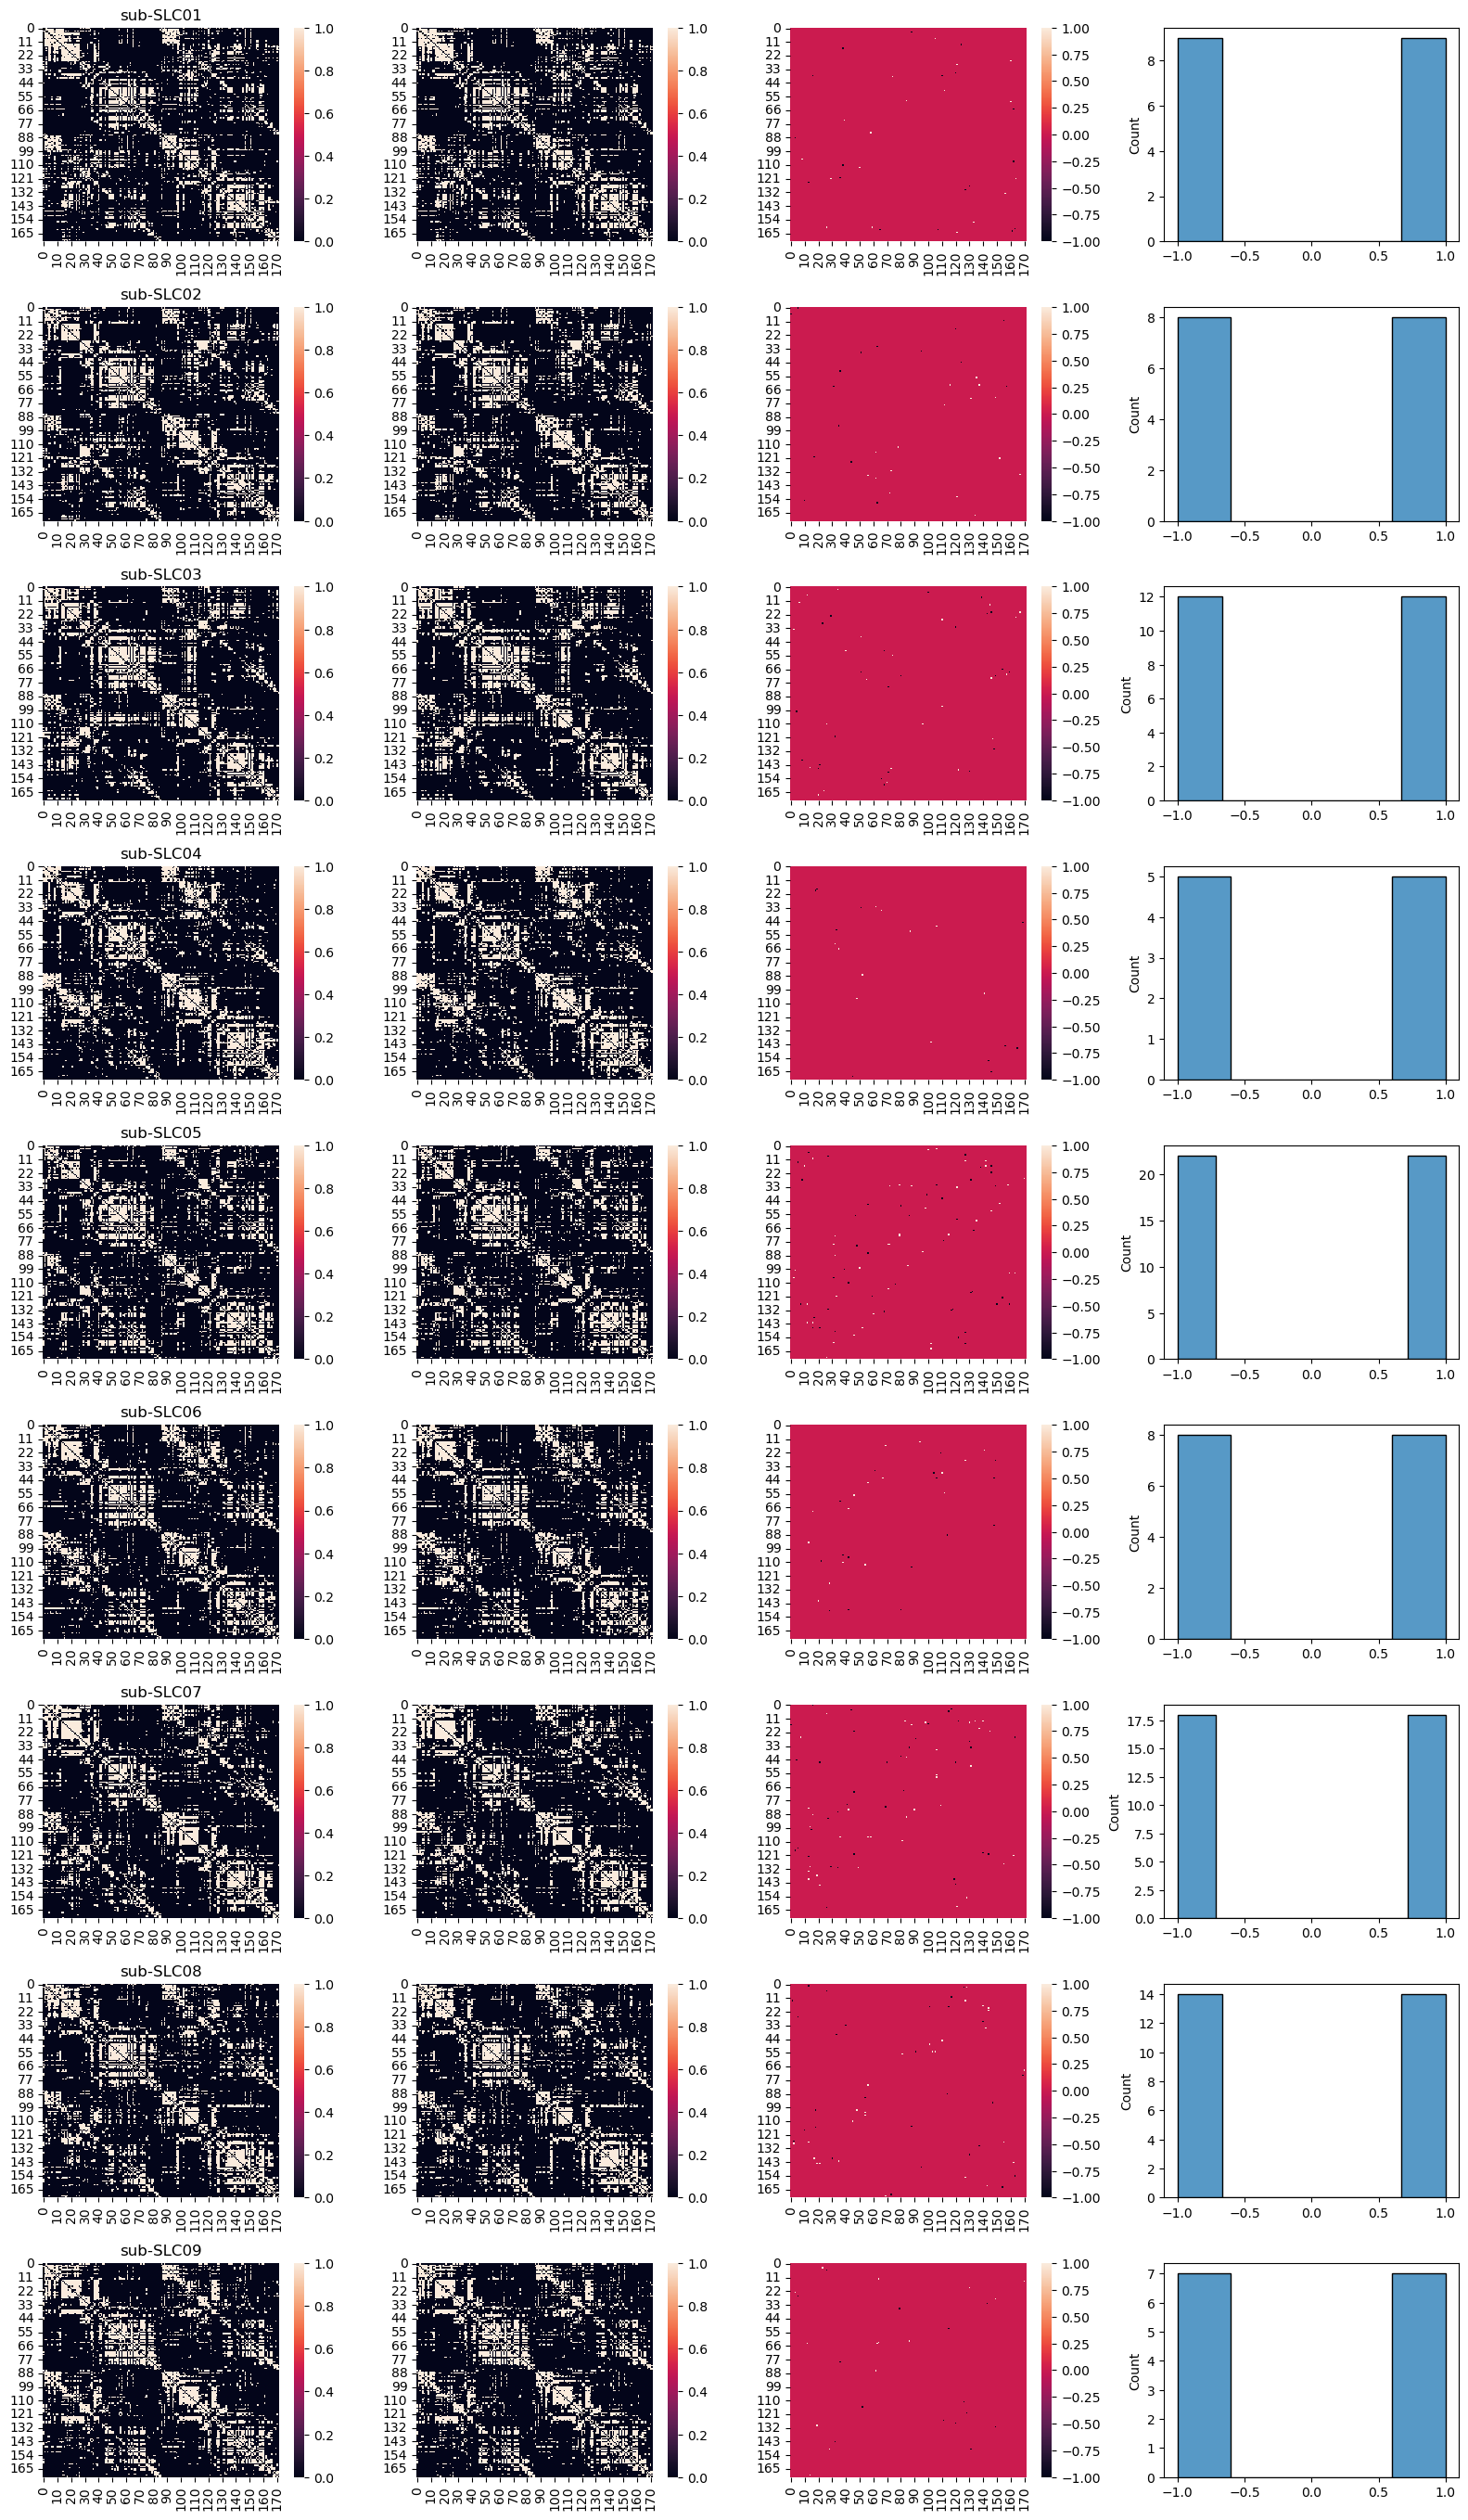

In [12]:
ncols = 4
nrows = len(As)

a = 20 / 5
b = a * 0.75 #* 4/7

fig, axs = plt.subplots(
    nrows=nrows, ncols=ncols,
    figsize=(a*ncols, b*nrows),
    sharex=False, sharey=False,
)
fig.tight_layout(h_pad=3, w_pad=3)

for idx in range(len(As)):
    A = As[idx]
    Ac = As_concat[idx]
    
    ax = axs[idx, 0]
    sns.heatmap(A, ax=ax)
    ax.set(title=f'sub-SLC{idx+1:02d}')
    
    ax = axs[idx, 1]
    sns.heatmap(Ac, ax=ax)
        
    ax = axs[idx, 2]
    sns.heatmap(A - Ac, ax=ax)
    
    ax = axs[idx, 3]
    vals, _ = _upper_triangle_bool(A - Ac)
    sns.histplot(vals[vals != 0], ax=ax)
    

In [13]:
def _upper_triangle_bool(A):
    n = A.shape[0]
    iu = np.triu_indices(n, k=1)
    return A[iu].astype(bool), iu

def _safe_pearsonr(x, y):
    x = np.asarray(x); y = np.asarray(y)
    if np.allclose(np.std(x), 0) and np.allclose(np.std(y), 0):
        # both constant -> perfectly "correlated" by construction
        return 1.0
    if np.allclose(np.std(x), 0) or np.allclose(np.std(y), 0):
        # one constant, the other not -> undefined; return 0.0
        return 0.0
    r, _ = pearsonr(x, y)
    return float(r)

def _norm_laplacian_eigs(A, k=None):
    # normalized Laplacian eigenvalues in ascending order (in [0,2])
    L = csgraph_laplacian(A, normed=True)
    # dense eigvals is fine for n~100-1000; swap to sparse eigs if needed
    evals = np.linalg.eigvalsh(L)
    evals = np.clip(np.real(evals), 0.0, 2.0)
    if k is not None:
        k = min(k, len(evals))
        return np.sort(evals)[:k]
    return np.sort(evals)

In [14]:
# ---------- (1) Edge overlap & significance ----------
def edge_overlap_metrics(A, B):
    assert A.shape == B.shape, "A and B must be the same size"
    assert np.allclose(A, A.T) and np.allclose(B, B.T), "A, B must be symmetric"
    assert np.all(np.diag(A) == 0) and np.all(np.diag(B) == 0), "Zero diagonal required"
    au, _ = _upper_triangle_bool(A)
    bu, _ = _upper_triangle_bool(B)
    n = A.shape[0]
    M = n * (n - 1) // 2
    mA = int(au.sum()); mB = int(bu.sum())
    if mA != mB:
        raise ValueError(f"Edge counts differ: |E(A)|={mA}, |E(B)|={mB}. "
                         "Ensure identical density/thresholding.")
    m = mA
    k = int(np.sum(au & bu))
    # metrics
    jaccard = k / (2 * m - k) if (2 * m - k) > 0 else 0.0
    recall = k / m if m > 0 else 0.0  # equals precision here since |E| equal
    hamming_frac = 2 * (m - k) / M
    # hypergeometric tail P(K >= k)
    pval = hypergeom.sf(k - 1, M, m, m)
    return {
        "n": n, "M": M, "m": m, "k": k,
        "jaccard": jaccard,
        "recall": recall,
        "hamming_frac": hamming_frac,
        "hypergeom_p": float(pval),
    }

In [15]:
# ---------- (2) Node-wise structure ----------
def nodewise_correlations(A, B):
    degA = A.sum(axis=1); degB = B.sum(axis=1)
    degree_r = _safe_pearsonr(degA, degB)

    GA = nx.from_numpy_array(A)
    GB = nx.from_numpy_array(B)
    cA_dict = nx.clustering(GA)  # local clustering coef per node
    cB_dict = nx.clustering(GB)
    cA = np.array([cA_dict[i] for i in range(A.shape[0])])
    cB = np.array([cB_dict[i] for i in range(B.shape[0])])
    clustering_r = _safe_pearsonr(cA, cB)

    return {
        "degree_r": degree_r,
        "clustering_r": clustering_r,
        "degA": degA, "degB": degB, "cA": cA, "cB": cB,
    }

In [16]:
# ---------- (3) Spectral/global shape ----------
def spectral_distances(A, B, k_top=20, use_wasserstein=True):
    evalsA_full = _norm_laplacian_eigs(A, k=None)
    evalsB_full = _norm_laplacian_eigs(B, k=None)
    k = min(k_top, len(evalsA_full), len(evalsB_full))
    evalsA_top = evalsA_full[:k]
    evalsB_top = evalsB_full[:k]
    l2_top = float(np.linalg.norm(evalsA_top - evalsB_top))
    # Wasserstein between full spectra in [0,2]
    w_full = float(wasserstein_distance(evalsA_full, evalsB_full)) if use_wasserstein else None
    return {
        "spec_l2_topk": l2_top,
        "spec_wasserstein_full": w_full,
        "k_top": k,
    }

In [17]:
# ---------- (5) Decision rule (configurable thresholds) ----------
DEFAULT_THRESHOLDS = {
    # Step (1): edge overlap
    "jaccard_min": 0.30,          # chance at p=0.2 is ~0.111; >0.30 is strong
    "hypergeom_p_max": 1e-3,      # significantly above chance
    # Step (2): node-wise correlations
    "degree_r_min": 0.90,
    "clustering_r_min": 0.85,
    # Step (3): spectral distances (normalized Laplacian eigenvalues in [0,2])
    "spec_l2_topk_max": 0.50,     # len-topk dependent; tune if needed
    "spec_wass_full_max": 0.05,   # conservative; tune if needed
}

def go_no_go(metrics, thresholds=None):
    """Return (decision_bool, reasons_list)."""
    th = DEFAULT_THRESHOLDS.copy()
    if thresholds:
        th.update(thresholds)

    reasons = []
    ok = True

    # (1)
    if metrics["jaccard"] < th["jaccard_min"]:
        ok = False; reasons.append(f"Jaccard {metrics['jaccard']:.3f} < {th['jaccard_min']}")
    if metrics["hypergeom_p"] > th["hypergeom_p_max"]:
        ok = False; reasons.append(f"hypergeom p {metrics['hypergeom_p']:.2e} > {th['hypergeom_p_max']}")

    # (2)
    if metrics["degree_r"] < th["degree_r_min"]:
        ok = False; reasons.append(f"degree r {metrics['degree_r']:.3f} < {th['degree_r_min']}")
    if metrics["clustering_r"] < th["clustering_r_min"]:
        ok = False; reasons.append(f"clustering r {metrics['clustering_r']:.3f} < {th['clustering_r_min']}")

    # (3)
    if metrics["spec_l2_topk"] > th["spec_l2_topk_max"]:
        ok = False; reasons.append(f"spec ℓ2(top-k) {metrics['spec_l2_topk']:.3f} > {th['spec_l2_topk_max']}")
    if metrics["spec_wasserstein_full"] is not None and metrics["spec_wasserstein_full"] > th["spec_wass_full_max"]:
        ok = False; reasons.append(f"spec W₁(full) {metrics['spec_wasserstein_full']:.3f} > {th['spec_wass_full_max']}")

    return ok, reasons


In [18]:
# ---------- One-stop per-animal ----------
def compare_graphs(A, B, k_top=20, thresholds=None):
    out1 = edge_overlap_metrics(A, B)
    out2 = nodewise_correlations(A, B)
    out3 = spectral_distances(A, B, k_top=k_top)
    merged = {**out1, **{k: v for k, v in out2.items() if k not in ("degA","degB","cA","cB")}, **out3}
    decision, reasons = go_no_go(merged, thresholds=thresholds)
    merged["go_no_go"] = bool(decision)
    merged["reasons"] = "; ".join(reasons) if reasons else ""
    return merged

In [19]:
# ---------- Batch over animals ----------
def compare_batches(A_list, B_list, k_top=20, thresholds=None, ids=None):
    """
    A_list, B_list: lists of numpy adjacency matrices (same order of animals).
    ids: optional list of animal IDs; default 0..len-1
    """
    assert len(A_list) == len(B_list)
    n_animals = len(A_list)
    if ids is None:
        ids = list(range(n_animals))
    rows = []
    for i, (A, B, aid) in enumerate(zip(A_list, B_list, ids)):
        res = compare_graphs(A, B, k_top=k_top, thresholds=thresholds)
        res["animal_id"] = aid
        rows.append(res)
    cols = ["animal_id","n","M","m","k",
            "jaccard","recall","hamming_frac","hypergeom_p",
            "degree_r","clustering_r",
            "spec_l2_topk","spec_wasserstein_full","k_top",
            "go_no_go","reasons"]
    return pd.DataFrame(rows)[cols]


In [20]:
# go_no_go == True => the graphs are similar enough to skip fitting SBMs again.
animal_ids = [f'sub-SLC{idx:02d}' for idx in range(len(As))]
df = compare_batches(As, As_concat, k_top=20, ids=animal_ids)

In [21]:
df

,animal_id,n,M,m,k,jaccard,recall,hamming_frac,hypergeom_p,degree_r,clustering_r,spec_l2_topk,spec_wasserstein_full,k_top,go_no_go,reasons
0,sub-SLC00,172,14706,2942,2933,0.993900,0.996941,0.001224,0.0,0.999155,0.997140,0.006754,0.001046,20,True,
1,sub-SLC01,172,14706,2942,2934,0.994576,0.997281,0.001088,0.0,0.999105,0.995964,0.005417,0.000784,20,True,
2,sub-SLC02,172,14706,2942,2930,0.991875,0.995921,0.001632,0.0,0.999128,0.997696,0.007753,0.000909,20,True,
3,sub-SLC03,172,14706,2942,2937,0.996607,0.998300,0.000680,0.0,0.999527,0.997680,0.004750,0.000821,20,True,
4,sub-SLC04,172,14706,2942,2920,0.985155,0.992522,0.002992,0.0,0.998646,0.993278,0.008644,0.001176,20,True,
5,sub-SLC05,172,14706,2942,2934,0.994576,0.997281,0.001088,0.0,0.999381,0.997707,0.005902,0.000842,20,True,
6,sub-SLC06,172,14706,2942,2924,0.987838,0.993882,0.002448,0.0,0.997987,0.995212,0.009529,0.001133,20,True,
7,sub-SLC07,172,14706,2942,2928,0.990528,0.995241,0.001904,0.0,0.998831,0.994066,0.015887,0.001257,20,True,
8,sub-SLC08,172,14706,2942,2935,0.995253,0.997621,0.000952,0.0,0.999354,0.997008,0.005993,0.000874,20,True,


In [23]:
vals = df['spec_wasserstein_full']
vals.mean(), vals.std()

(0.000982506651332637, 0.00017377010590941897)